In [1]:
from IPython.core.pylabtools import figsize
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('all_proteins_df_final.csv', index_col='accession')
df = df.drop(['Unnamed: 0'], axis=1)

In [3]:
# Subsetting data to narrow the classes seen by machine learning algorithms
# Also have classes "multiple" and "other"
df = df[(df.localization == 'membrane') | (df.localization == 'nucleus') | (df.localization == 'mitochondria')
        | (df.localization == 'secreted') | (df.localization == 'cytoskeleton')]

df = df.reset_index()

# Applying Natural Language Processing Methods to Primary Amino Acid Sequences

In [4]:
# Segment dataframe into just sequence and localization data to Word2Vec model
sequences = df.sequence
localizations = df.localization

# Using join function on the sequences to add space between amino acids
seq = [' '.join(sequence) for sequence in sequences]

Word2Vec and other natural language processing (NLP) algorithms follow the logic of a sentence being string of text broken up by spaces, which delineate the words of the sentence. The join function above is used to add spaces between the amino acids in the primary amino acid sequence, causing NLP algorithms to view a primary amino acid sequence as a sentence where the words are amino acids instead of a single long word.

## Vectorizing Amino Acid Sequences

A common technique in NLP is "vectorizing" the words in a given sentence. This converts text numerical data by generating a Term-Document matrix based on the words used and their resepective frequencies in the entire document.<br>
<br>
Within the context of an amino acid sequence there are only 22 possible "words" in our dictionary, but the frequency of amino acids within certain localization groups could provide useful information when predicting the localization of a new protein.

In [5]:
# Vectorizing amino acid sequences with SciKitLearn's Tfidf Vectorizor
from sklearn.feature_extraction.text import TfidfVectorizer

# Analyzer parameter set to 'char_wb' so that vectorizor recognizes the single character "words" that are amino acids
tfidf_vect = TfidfVectorizer(analyzer='char_wb')
X_tfidf = tfidf_vect.fit_transform(seq)

# Create dataframe with vectorized data
X_tf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vect.get_feature_names())

## Word2Vec Analysis of Amino Acid Sequences

Vectorizing the amino acid sequences above provides significant information on the frequencies of certain amino acids within a protein, but no insight into the context in which these proteins appear. To generate features that reflect contextual information the algorithm Word2Vec is used. Word2Vec a neural network that vectorizes words while taking context into account by analyzing a given word within a context window. 

### Defining functions to convert Word2Vec output to vector space

In [6]:
#credit to www.sadfjasdf.com/dsfdf for the functions below

def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector

def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

### Training Word2Vec model on amino acid sequence data

In [7]:
from gensim.models import word2vec

# Set values for various parameters
feature_size = 50    # Word vector dimensionality  
window_context = 15          # Context window size                                                                                    
min_word_count = 0   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

# Generate Word2Vec model with features listed above, with the addition of sg=1
# Setting sg=1 implements "Skip-Grams" which centers the context on a single word and analyzes the context around each word
w2v_model = word2vec.Word2Vec(seq, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, sg=1, iter=100)

# Get document level embeddings
w2v_feature_array = averaged_word_vectorizer(corpus=seq, model=w2v_model,
                                             num_features=feature_size)

/Users/zosking/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [8]:
# Merge the vectorized amino acid features with Word2Vec features and check shape to confirm merge
X_NLP = X_tf_df.merge(pd.DataFrame(w2v_feature_array), left_index=True, right_index=True)
X_NLP.shape

(28056, 74)

In [12]:
# List of features to be included from original protein data set
structural = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y','U',
 'positive_aa','negative_aa','nonpolar_aa','polar_aa','positive_ratio','negative_ratio','polarity_ratio',
 'DOMAINS_AND_SITES','MOLECULE_PROCESSING','MUTAGENESIS','PTM','SEQUENCE_INFORMATION','STRUCTURAL',
 'TOPOLOGY','VARIANTS','ACT_SITE','BINDING','CARBOHYD','CA_BIND','CHAIN','COILED','COMPBIAS',
 'CONFLICT','CROSSLNK','DISULFID','DNA_BIND','DOMAIN','HELIX','INIT_MET','INTRAMEM','LIPID',
 'METAL','MOD_RES','MOTIF','MUTAGEN','NON_CONS','NON_STD','NON_TER','NP_BIND','PEPTIDE','PROPEP',
 'REGION','REPEAT','SIGNAL','SITE','STRAND','TOPO_DOM','TRANSIT','TRANSMEM','TURN','VARIANT',
 'VAR_SEQ','ZN_FING','positive_freq','negative_freq']

# Filter dataframe by the features to be added to the NLP data set
structural_features = df[structural]
structural_features = structural_features.reset_index()

In [13]:
# Merge NLP dataframe with protein database features to generate final data set
X = X_NLP.merge(structural_features, left_index=True, right_index=True)
y = df.localization

print("Shape X: ", X.shape)
print("Shape y: ", y.shape)

Shape X:  (28056, 151)
Shape y:  (28056,)


The dataset is now ready for testing with machine learning algorithms!

# Principal Component Analysis of Protein Data

To get an idea of the grouping of these data, principal component analysis (PCA) is performed to analyze the variance explained by features and reduce the dimensionality of the data and allow for the visualization of how it is grouped.

## Explained Variance of Features

In [14]:
# These data are currently in a variety of scales, so a scaler is used prior to some analyses
# Scale features for PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
from sklearn.decomposition import PCA

pca = PCA()
pca_components = pca.fit(X_scaled)

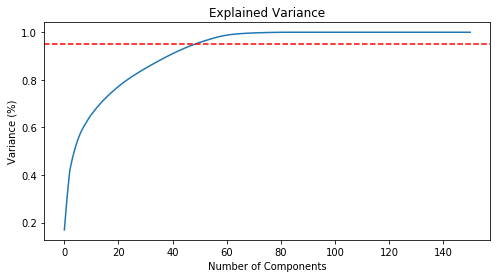

In [16]:
# Figure showing the number of components needed to explain the variance in the dataset.
plt.figure(figsize=(8,4))

plt.plot(np.cumsum(pca_components.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') 
plt.axhline(y=0.95, color='r', linestyle='--')
plt.title('Explained Variance')
plt.show()

From the above graph we see that 95% of variance can be explained with around 50 components.

## Two Component Principal Component Analysis

In [17]:
pca = PCA(n_components = 2)
pca_2components = pca.fit_transform(X_scaled)

df_pc = pd.DataFrame(data=pca_2components, columns=['pca1', 'pca2'])
df_pc = pd.concat([df_pc, df[['localization']]],axis=1)

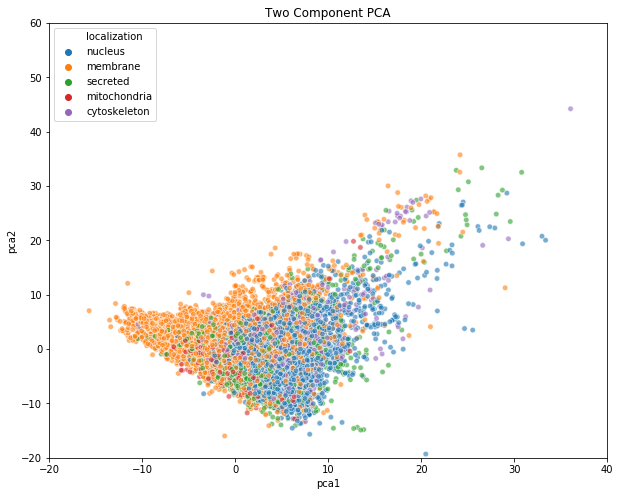

In [18]:
plt.figure(figsize=(10,8))

sns.scatterplot(x='pca1', y='pca2', hue='localization', data=df_pc, alpha=0.6, s=30)
plt.xlim([-20,40])
plt.ylim([-20,60])
plt.title('Two Component PCA')
plt.show()

In [19]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.16909219 0.13723347]


When the dimensions of these data are shrunk from 172 to 2, there is not a clear grouping between most of the localization categories. However, 2 components explain a small proportion of the variance in the data.

# Initial Testing of Machine Learning Algorithms

To determine which machine learning algorithm to use on these data, multiple algorithms are tested at default settings.

In [20]:
# Import the necessary modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [21]:
y.value_counts()

membrane        12696
nucleus          9482
secreted         2901
mitochondria     1789
cytoskeleton     1188
Name: localization, dtype: int64

It must be noted that the data collected disproportionately reflects membrane-localized proteins. To address the data were resampled to normalize the number of samples in each class. This resampled dataset will be tested along side the scaled or unscaled datasets.

In [22]:
# Upsampling data to the length of the nucleus class
from sklearn.utils import resample

# setting up testing and training sets
X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(X, y, test_size=0.3, random_state=42)

# concatenate our training data back together
X2 = pd.concat([X_train_up, y_train_up], axis=1)

# separate classes
cytoskeleton = X2[X2.localization=='cytoskeleton']
membrane = X2[X2.localization=='membrane']
mitochondria = X2[X2.localization=='mitochondria']
nucleus = X2[X2.localization=='nucleus']
secreted = X2[X2.localization=='secreted']

# upsample minority
cytoskeleton_downsampled = resample(cytoskeleton,
                          replace=True, # sample with replacement
                          n_samples=len(nucleus), # match number in nucleus class
                          random_state=42) # reproducible results
mitochondria_upsampled = resample(mitochondria,
                          replace=True, 
                          n_samples=len(nucleus), 
                          random_state=42) 
secreted_upsampled = resample(secreted,
                          replace=True, 
                          n_samples=len(nucleus), 
                          random_state=42)
membrane_upsampled = resample(membrane,
                          replace=True,
                          n_samples=len(nucleus),
                          random_state=42) 

# combine majority and upsampled minority
upsampled = pd.concat([nucleus, secreted_upsampled, cytoskeleton_downsampled, mitochondria_upsampled, membrane_upsampled])

y_train_up = upsampled.localization
X_train_up = upsampled.drop('localization', axis=1)

#scaling upsampled training and testing data
scaler = StandardScaler()  
scaler.fit(X_train_up) 
X_train_up_scaled = scaler.transform(X_train_up)
X_test_up_scaled = scaler.transform(X_test_up)

In [24]:
upsampled.localization.value_counts()

secreted        6621
cytoskeleton    6621
membrane        6621
mitochondria    6621
nucleus         6621
Name: localization, dtype: int64

At this point we have four different versions of X that are available for testing:
1. X
2. X_scaled 
3. X_up (resampled data to normalize category)
4. X_scaled_up

All four of these will not be tested per algorithm, instead a best guess will be used to determine which versions of X may be most informative.

## Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression


X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.3,random_state=21)

# Create the classifier: logreg
logreg = LogisticRegression(multi_class = 'auto')

# Fit the classifier to the training data
logreg.fit(X_train,y_train)

# Predict the labels of the test set: y_pred
y_pred = logreg.predict(X_test)

# Compute and print the confusion matrix and classification report
print(classification_report(y_test, y_pred))
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred))

/Users/zosking/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

cytoskeleton       0.49      0.13      0.20       365
    membrane       0.91      0.84      0.88      3751
mitochondria       0.96      0.54      0.69       540
     nucleus       0.75      0.96      0.84      2871
    secreted       0.88      0.88      0.88       890

    accuracy                           0.84      8417
   macro avg       0.80      0.67      0.70      8417
weighted avg       0.84      0.84      0.82      8417

Confusion Matrix: 
[[  46   39    2  278    0]
 [  12 3158    7  467  107]
 [   1  116  292  131    0]
 [  31   83    1 2755    1]
 [   3   63    1   43  780]]


Logistic regression with default settings performs fairly well with most categories at default settings. However, this algorithm performs expremely poorly with the cytoskeleton class, where it cytoskeletally localized proteins incorrectly predicted to be either membrane localized or nuclear localized. 

In [26]:
from sklearn.linear_model import LogisticRegression

# Create the classifier: logreg
logreg = LogisticRegression(multi_class = 'auto')

# Fit the classifier to the training data
logreg.fit(X_train_up_scaled,y_train_up)

# Predict the labels of the test set: y_pred
y_pred = logreg.predict(X_test_up_scaled)

# Compute and print the confusion matrix and classification report
print(classification_report(y_test_up, y_pred))
print("Confusion Matrix: ")
print(confusion_matrix(y_test_up, y_pred))

/Users/zosking/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

cytoskeleton       0.20      0.78      0.31       374
    membrane       0.96      0.69      0.80      3800
mitochondria       0.55      0.79      0.65       530
     nucleus       0.86      0.69      0.77      2861
    secreted       0.66      0.91      0.77       852

    accuracy                           0.72      8417
   macro avg       0.65      0.77      0.66      8417
weighted avg       0.84      0.72      0.76      8417

Confusion Matrix: 
[[ 292   15   12   53    2]
 [ 430 2604  190  193  383]
 [  39   31  417   42    1]
 [ 716   34  118 1983   10]
 [  10   23   15   29  775]]


Upsampling the majority of the classes hurt the ability of this algorithm to predict all classes except for the cytoskeleton class, which almost doubled in f1 score.

## Support Vector Machine

In [27]:
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.3,random_state=21)

svm = SVC()
svm.fit(X_train,y_train)

# Predict the labels of the test set: y_pred
y_pred = svm.predict(X_test)

# Compute and print the confusion matrix and classification report
print(classification_report(y_test, y_pred))
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred))

/Users/zosking/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


              precision    recall  f1-score   support

cytoskeleton       0.71      0.13      0.22       365
    membrane       0.92      0.86      0.89      3751
mitochondria       0.98      0.62      0.76       540
     nucleus       0.76      0.97      0.85      2871
    secreted       0.93      0.87      0.90       890

    accuracy                           0.85      8417
   macro avg       0.86      0.69      0.72      8417
weighted avg       0.86      0.85      0.84      8417

Confusion Matrix: 
[[  48   43    1  273    0]
 [   6 3214    6  463   62]
 [   1   88  334  117    0]
 [  10   74    0 2786    1]
 [   3   63    1   45  778]]


In [28]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(X_train_up_scaled,y_train_up)

# Predict the labels of the test set: y_pred
y_pred = svm.predict(X_test_up_scaled)

# Compute and print the confusion matrix and classification report
print(classification_report(y_test_up, y_pred))
print("Confusion Matrix: ")
print(confusion_matrix(y_test_up, y_pred))

/Users/zosking/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


              precision    recall  f1-score   support

cytoskeleton       0.31      0.80      0.44       374
    membrane       0.97      0.79      0.87      3800
mitochondria       0.70      0.83      0.76       530
     nucleus       0.85      0.83      0.84      2861
    secreted       0.85      0.91      0.87       852

    accuracy                           0.82      8417
   macro avg       0.73      0.83      0.76      8417
weighted avg       0.87      0.82      0.84      8417

Confusion Matrix: 
[[ 300    7    7   56    4]
 [ 277 2999  111  282  131]
 [  16   24  442   48    0]
 [ 381   25   65 2384    6]
 [   8   28    9   35  772]]


## Random Forest Classifier

In [29]:
from sklearn.ensemble import RandomForestClassifier

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=21)

forest = RandomForestClassifier()

forest.fit(X_train,y_train)

y_pred = forest.predict(X_test)

# Compute and print the confusion matrix and classification report
print(classification_report(y_test, y_pred))
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred))

/Users/zosking/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

cytoskeleton       0.67      0.36      0.47       365
    membrane       0.91      0.91      0.91      3751
mitochondria       0.93      0.67      0.78       540
     nucleus       0.83      0.94      0.88      2871
    secreted       0.94      0.89      0.91       890

    accuracy                           0.88      8417
   macro avg       0.86      0.75      0.79      8417
weighted avg       0.88      0.88      0.87      8417

Confusion Matrix: 
[[ 132   54    3  176    0]
 [  25 3409    9  260   48]
 [   5  103  360   72    0]
 [  32  133   16 2686    4]
 [   2   61    0   37  790]]


In [30]:
forest = RandomForestClassifier()

forest.fit(X_train_up,y_train_up)

y_pred = forest.predict(X_test_up)

# Compute and print the confusion matrix and classification report
print(classification_report(y_test_up, y_pred))
print("Confusion Matrix: ")
print(confusion_matrix(y_test_up, y_pred))

/Users/zosking/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

cytoskeleton       0.63      0.55      0.58       374
    membrane       0.96      0.85      0.90      3800
mitochondria       0.84      0.78      0.80       530
     nucleus       0.81      0.95      0.87      2861
    secreted       0.90      0.91      0.90       852

    accuracy                           0.87      8417
   macro avg       0.83      0.81      0.81      8417
weighted avg       0.88      0.87      0.87      8417

Confusion Matrix: 
[[ 204   20    5  142    3]
 [  63 3239   44  371   83]
 [   2   39  411   77    1]
 [  52   63   28 2714    4]
 [   3   30    4   39  776]]


## Multi-Layer Perceptron

In [31]:
from sklearn.neural_network import MLPClassifier

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.3,random_state=21)

clf = MLPClassifier()

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
# Compute and print the confusion matrix and classification report
print(classification_report(y_test, y_pred))
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred))

/Users/zosking/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

cytoskeleton       0.57      0.43      0.49       365
    membrane       0.91      0.89      0.90      3751
mitochondria       0.79      0.80      0.79       540
     nucleus       0.85      0.91      0.88      2871
    secreted       0.91      0.89      0.90       890

    accuracy                           0.87      8417
   macro avg       0.80      0.78      0.79      8417
weighted avg       0.87      0.87      0.87      8417

Confusion Matrix: 
[[ 158   55    6  141    5]
 [  50 3327   58  258   58]
 [  10   41  430   55    4]
 [  57  149   46 2605   14]
 [   2   71    5   23  789]]


In [32]:
clf = MLPClassifier()

clf.fit(X_train_up_scaled, y_train_up)

y_pred = clf.predict(X_test_up_scaled)
# Compute and print the confusion matrix and classification report
print(classification_report(y_test_up, y_pred))
print("Confusion Matrix: ")
print(confusion_matrix(y_test_up, y_pred))

/Users/zosking/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

cytoskeleton       0.47      0.57      0.51       374
    membrane       0.92      0.86      0.89      3800
mitochondria       0.79      0.80      0.79       530
     nucleus       0.85      0.88      0.87      2861
    secreted       0.83      0.88      0.85       852

    accuracy                           0.85      8417
   macro avg       0.77      0.80      0.78      8417
weighted avg       0.86      0.85      0.85      8417

Confusion Matrix: 
[[ 212   35    9  111    7]
 [  92 3261   69  257  121]
 [  13   49  423   44    1]
 [ 130  146   34 2523   28]
 [   5   59    1   36  751]]


## Gradient Boosting

In [33]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()

model.fit(X_train_up_scaled,y_train_up)

y_pred = model.predict(X_test_up_scaled)
# Compute and print the confusion matrix and classification report
print(classification_report(y_test_up, y_pred))
print("Confusion Matrix: ")
print(confusion_matrix(y_test_up, y_pred))

              precision    recall  f1-score   support

cytoskeleton       0.29      0.77      0.42       374
    membrane       0.97      0.81      0.89      3800
mitochondria       0.65      0.82      0.73       530
     nucleus       0.87      0.81      0.84      2861
    secreted       0.87      0.92      0.89       852

    accuracy                           0.82      8417
   macro avg       0.73      0.83      0.75      8417
weighted avg       0.88      0.82      0.84      8417

Confusion Matrix: 
[[ 289   11    9   58    7]
 [ 260 3091  121  218  110]
 [  18   31  434   47    0]
 [ 427   24   89 2316    5]
 [   9   19   10   29  785]]


After testing numerous ML algorithms with default settings, the three most promising algorithms are:
1. Support Vector Machine (upsampled)
2. Random Forest Classifier (upsampled)
3. Multi-Layer Perceptron

# Cross Validation of Machine Learning Algorithms

## Support Vector Machine CV

In [40]:
from sklearn.model_selection import GridSearchCV

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"C": [1,10],
              "kernel": ['rbf','poly', 'linear'],
              "decision_function_shape":['ovo','ovr']}

svm = SVC()
svm_cv = GridSearchCV(svm, param_dist, cv=3)

# Fit it to the data
svm_cv.fit(X_train_up_scaled,y_train_up)

print("Tuned Random Forest Parameters: {}".format(svm_cv.best_params_)) 
print("Best score is {}".format(svm_cv.best_score_))

/Users/zosking/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/zosking/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/zosking/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/zosking/anaconda3/lib/python3.7/site-packa

Tuned Random Forest Parameters: {'C': 10, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}
Best score is 0.938438302371243


In [44]:
svm = SVC(C=10, decision_function_shape='ovo', kernel='rbf')
svm.fit(X_train_up_scaled,y_train_up)

# Predict the labels of the test set: y_pred
y_pred = svm.predict(X_test_up_scaled)

# Compute and print the confusion matrix and classification report
print(classification_report(y_test_up, y_pred))
print("Confusion Matrix: ")
print(confusion_matrix(y_test_up, y_pred))

/Users/zosking/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


              precision    recall  f1-score   support

cytoskeleton       0.46      0.71      0.55       374
    membrane       0.96      0.85      0.90      3800
mitochondria       0.81      0.84      0.83       530
     nucleus       0.85      0.91      0.88      2861
    secreted       0.89      0.91      0.90       852

    accuracy                           0.87      8417
   macro avg       0.79      0.84      0.81      8417
weighted avg       0.89      0.87      0.87      8417

Confusion Matrix: 
[[ 264   16    8   83    3]
 [ 146 3220   55  296   83]
 [   8   26  444   51    1]
 [ 157   48   36 2614    6]
 [   5   36    3   33  775]]


## Random Forest CV

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=21)

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [1000,5000],
              "max_features": ['sqrt','log2'],
              "n_estimators":[100,500],
              "criterion": ["gini", "entropy"]}

forest = RandomForestClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
forest_cv = GridSearchCV(forest, param_dist, cv=3)

# Fit it to the data
forest_cv.fit(X_train,y_train)

print("Tuned Random Forest Parameters: {}".format(forest_cv.best_params_)) 
print("Best score is {}".format(forest_cv.best_score_))

Tuned Random Forest Parameters: {'criterion': 'gini', 'max_depth': 1000, 'max_features': 'sqrt', 'n_estimators': 500}
Best score is 0.8805947349661388


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=21)

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [5000,15000],
              "max_features": ['sqrt'],
              "n_estimators":[500],
              "criterion": ["gini"]}

forest = RandomForestClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
forest_cv = GridSearchCV(forest, param_dist, cv=3)

# Fit it to the data
forest_cv.fit(X_train,y_train)

print("Tuned Random Forest Parameters: {}".format(forest_cv.best_params_)) 
print("Best score is {}".format(forest_cv.best_score_))

Tuned Random Forest Parameters: {'criterion': 'gini', 'max_depth': 15000, 'max_features': 'sqrt', 'n_estimators': 500}
Best score is 0.8803401395183054


In [56]:
forest = RandomForestClassifier(criterion='gini', max_depth=15000, max_features='sqrt', n_estimators=50)

forest.fit(X_train_up,y_train_up)

y_pred = forest.predict(X_test_up)

# Compute and print the confusion matrix and classification report
print(classification_report(y_test_up, y_pred))
print("Confusion Matrix: ")
print(confusion_matrix(y_test_up, y_pred))

              precision    recall  f1-score   support

cytoskeleton       0.80      0.50      0.62       374
    membrane       0.98      0.85      0.91      3800
mitochondria       0.92      0.78      0.84       530
     nucleus       0.80      0.98      0.88      2861
    secreted       0.88      0.93      0.90       852

    accuracy                           0.88      8417
   macro avg       0.87      0.81      0.83      8417
weighted avg       0.89      0.88      0.88      8417

Confusion Matrix: 
[[ 188    9    1  173    3]
 [  27 3216   28  422  107]
 [   0   38  412   80    0]
 [  19   15    8 2816    3]
 [   0   17    0   42  793]]


## Multi-Layer Perceptron CV

In [49]:
# Setup the parameters and distributions to sample from: param_dist
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.3,random_state=21)

param_dist = {"hidden_layer_sizes": [(5000,),(20000,)],
              "activation": ['relu','logistic'],
              "solver":['lbfgs','sgd'],
              "max_iter":[10000,50000]}

mlp = MLPClassifier()
mlp_cv = GridSearchCV(mlp, param_dist, cv=3)

# Fit it to the data
mlp_cv.fit(X_train,y_train)

# Compute and print the confusion matrix and classification report
print("Tuned Random Forest Parameters: {}".format(mlp_cv.best_params_)) 
print("Best score is {}".format(mlp_cv.best_score_))

/Users/zosking/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:568: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/zosking/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:568: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/zosking/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:568: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


KeyboardInterrupt: 

In [55]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.3,random_state=21)

clf = MLPClassifier(hidden_layer_sizes=(5000,), activation='relu',solver='lbfgs',max_iter=10000)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
# Compute and print the confusion matrix and classification report
print(classification_report(y_test, y_pred))
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

cytoskeleton       0.59      0.56      0.58       365
    membrane       0.92      0.91      0.92      3751
mitochondria       0.84      0.80      0.82       540
     nucleus       0.88      0.91      0.90      2871
    secreted       0.93      0.89      0.91       890

    accuracy                           0.89      8417
   macro avg       0.83      0.82      0.82      8417
weighted avg       0.89      0.89      0.89      8417

Confusion Matrix: 
[[ 204   53    4  100    4]
 [  46 3431   53  183   38]
 [   6   46  433   54    1]
 [  85  135   21 2613   17]
 [   3   68    6   18  795]]


# Conclusions

After testing and cross-validating numerous machine learning algorithms, it appears that an accuracy in the upper 80% to lower 90% range is possible with this feature set. The macro average of f1-score was typically in the low 80% range, which could likely be improved with further tuning and ensemble learning techniques. 
<br><br>
The classes of membrane-localized , nucleus-localized, and secreted proteins performed particularly well, with f1-scores regularly in the low 90's. This suggests that a significant component in determining the localization of these proteins come from the content and arrangement of amino acids as well as basic protein structure. The high performance of these classes makes sense, given the highly polar residues that are required for membrane insertion, nuclear localization sequences required for entry of a protein into the nucleus, and the unique structural makeup of secreted proteins. Interestingly, mitochondria-localized proteins were less accurately predicted than the top three classes. I hypothesize that this is due to the complex makeup of mitochondria, which have multiple layers of membrane and different mechanisms for importing and exporting proteins. 
<br><br>
Of note is how poorly the cytoskeleton class performed relative to the other classes predicted, maxing around 60% in f1-score and is routinely confused for the nucleus class. Whether this is due to the small number of samples or due to fundamental biological reasons remains unclear. A useful comparison is the cytoskeleton with the secreted class, which are similar in their limited sample numbers. The average f1-score for secreted proteins is around 90% despite the small sample size. This implies that there may be a biological reason behind the inability to predict cytoskeletal localization. One possibility is that cytoskeletal proteins that localize in the nucleus for the purposes of DNA replication display an identity similar to a nuclear localized protein. This confusion was forseen and I attempted to rectify it in the labelling phase of data wrangling, but it is possible that a population of nuclear localized cytoskeletal proteins remains in the data set.

# Future Directions

1. **Download more data from the UniProt database:** The data presented in this project represent a small subset of proteins in the UniProt database. Due to technical reasons this study was restricted to human and mouse proteins, a raw dataset that consisted of a little bit less than 100,000 individual proteins. Through wrangling these data around 2/3rds of these proteins were deleted due to insufficient features or localizations other than what were tested. By broadening the proteomes of organisms downloaded, it is likely that prediction can improve.
<br><br>

2. **Stack ML algorithms:** In testing multiple ML algorithms and configurations of features, it became clear that different algorithms had different strengths and weaknesses. These differences were particularly stark in the context of the cytoskeleton class where depending on the algorithm and features included precision or recall could be as high as 80%, but never at the same time. Stacking different algorithms could possibly take their respective strengths and significantly improve prediction of the weakest class.
<br><br>

3. **Re-engineer the feature set studied:** While the features studied thusfar should be informative to protein localization, it is by no means a comprehensive feature set. The features used represent what I feel could be reasonably inferred for a newly discovered protein sequence. By adding features the differences between classes could become more clear to ML algorithms. Additionally, the use of NLP techniques like Word2Vec could likely be improved upon. The Word2Vec features generated here are the result of my best-guesses with minimal cross-validation. 
<br><br>

4. **Analyze different classes and/or redefine the classes included in the study:** A possible fundamental weakness in these data is the inaccurate labelling of classes. The scheme that I created is likely representative of a proteins true localization, but there is significant room for error in both how the classes were defined and if the data from Uniprot is accurate. Further tuning could be performed to determine the optimal classes to be included, possible combinations of classes to analyzed, and how to best label classes in the first place.